# Линейная классификация

Рассмотрим в работе способы построения линейной модели классификации.

Линейный классификатор представляет собой линейную модель, разделяющую два класса (-1, 1). Линейная модель описывается следующей формулой $\langle \omega, x \rangle + b = y$. Вектор весов $\omega$ - вектор нормали этой линейно модели. При $y = 0$, все точки $x$ принадлежат этой разделяющей прямой, при $y > 0$ объеты $x$ лежат с той стороны прямой линии, куда смотрит вектор весов $\omega$, при $y < 0$ с другой стороны прямой линии. Таким образом линейная модель разделяет все объекты на положительный и отрицательные, причем чем дальше объект лежит от прямой, тем большее абсолютное значение он имеет.

Необходимо ввести обозначение отступа:

$$M = y \langle \omega, x \rangle$$

Таким образом, если объект будет лежать со стороны своего класса (классифицироваться правильно), то $M$ всегда будет иметь положительное значение. В случае неправилной классификации отступ будет отрицательным.

Введем несколько loss-функцию, которые будет оптимизировать:

1. логистическая: $$\bar L(M) = \ln(1+ \exp(-M))$$

2. экспоненциальны: $$\bar L(M) = \exp(-M)$$

3. кусочно-линейная: $$\bar L(M) = max(0, 1-M))$$

Таким образом для каждого объекта будет вычислена его собственный штраф. Чтобы получить полную функцию потеря - просто проссумируем штрафы всех объектов.
Таким образом у нас будет функция, подсчитывающая штрафы для конкретной модели. Необходимо ее оптимизировать, для этого надо вычислить градиент и начать движение (изменение весов модели $\omega$) в сторону антиградиента с некоторым постоянным шагом.

## Задача
1. Написать функцию расчета функции потерь (loss-функции) и градиента функции. (выбрать любую функцию)
2. Реализовать градиентный спуск по всем данным.
3. Реализовать стохастический градиентный спуск.

In [80]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from math import log1p
%matplotlib inline

### Задача 1
Напишите две функции, которые будут получать на вход вектор весов, признаки и целевую переменную. Функции должны возвращать суммарную ошибку и градиент.

In [94]:
#exp
def loss(c_w0, c_w1, c_w2, x, y):
    error = 0
    for i in range(x.shape[0]):
        M = (c_w1 * x[i][0] + c_w2 * x[i][1] + c_w0) * y[i]
        #error += np.exp(-M)
        error += log1p(np.exp(-M))
    return error

def grad_loss(c_w0, c_w1, c_w2, x, y):
    #Универсальный вариант
    h = 0.001       
    l = loss(c_w0, c_w1, c_w2, x, y)
    #g0 = (loss(c_w0 + h, c_w1, c_w2, x, y) - l) / h
    #g1 = (loss(c_w0, c_w1 + h, c_w2, x, y) - l) / h
    #g2 = (loss(c_w0, c_w1, c_w2 + h, x, y) - l) / h
    
    #exp
    g0 = sum(-y * np.exp(-y * (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1])))
    g1 = sum(-y * x[:, 0] * np.exp(-y * (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1])))
    g2 = sum(-y * x[:, 1] * np.exp(-y * (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1])))
    
    #log
    g0 = sum(-y * (1 / (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1])))
    g1 = sum(-y * x[:, 0] * (1 / (-y * (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1]))))
    g2 = sum(-y * x[:, 1] * (1 / (-y * (c_w0 + c_w1 * x[:, 0] + c_w2 * x[:, 1]))))

    return (g0, g1, g2)

Дан набор данных.
Проведена нормализация данных по признакам и выставлены классы (-1, 1).

Проведите случайную линейную модель, постройте ее на графике и вычислите для нее суммарную функцию ошибки.
Проверьте, что суммарная функция ошибки считается правильно.

34.094457379519646


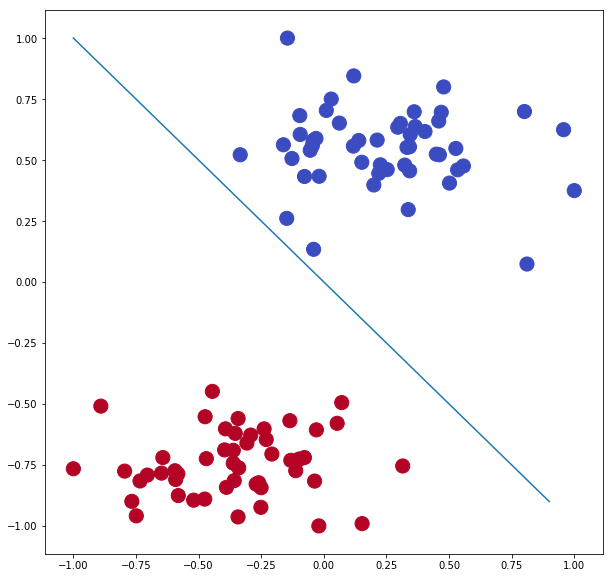

In [145]:
X, Y = make_blobs(n_samples=100, n_features=2, centers=2 ,cluster_std=1, random_state=17, center_box=(-10, 10))
cmap = plt.cm.coolwarm
plt.figure(figsize=(10,10))
X[:,0] = 2 * (X[:,0] - X[:,0].min()) / (X[:,0].max() - X[:,0].min()) - 1
X[:,1] = 2 * (X[:,1] - X[:,1].min()) / (X[:,1].max() - X[:,1].min()) - 1 
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

b = 0
k = -1
x = np.arange(-1, 1, 0.1)
kys = -1
y = -(k * x + b) / kys
plt.plot(x, y)

Y[Y == 0] = -1
#Y*=-1
print(loss(b, k, kys, X, Y))

### Задача 2. Реализация метода градиентного спуска
Постройте анимационную гифку схождения вашей линейной модели к данным. Подпишите loss к каждому кадру на гифке.

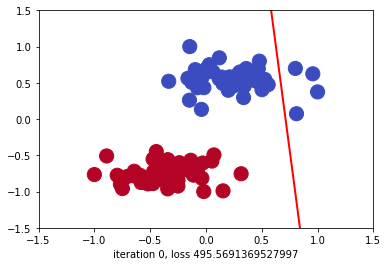

In [93]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

#Для экспоненциальной и логистической loss
#k = 1
#b = 2

#Для логистической loss
k = 10
b = -5

w2 = 1
m = 1e-2 # шаг обучения

# Данные
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

# Модель данных
line = lambda x1 : -(x1 * k + b)
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])

def update(i):
    global w, X, Y, m, k, b, w2
    
    label = 'iteration {0}, loss {1}'.format(i, loss(b, k, w2, X, Y))
    # Градиент в примере задан постоянными величинами
    # На деле после каждой итерации необходимо пересчитывать градиент и изменять веса модели.
    div_w0, div_w1, div_w2 = grad_loss(b, k, w2, X, Y)
    
    b  -= m * div_w0
    k  -= m * div_w1
    w2 -= m * div_w2
    
    #line = lambda c_x : (c_x * k + b) / w2
    line = lambda c_x : -(c_x * k + b) / w2
    
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 300))
rc('animation', html='html5')

In [49]:
anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

### Задача 3. Реализация стохастического градиентного спуска.
Используйте на каждой итерации не весь набор данных, а $n$ случайных объектов из выборки. Оформите результат схождения вашей модели в виде гифки.

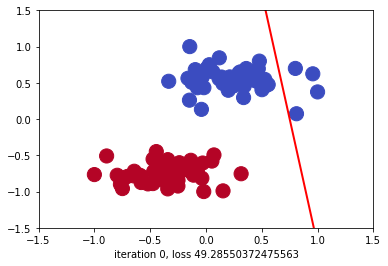

In [50]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc
from random import sample 

fig, ax = plt.subplots()

#Для экспоненциальной и логистической loss
#k = 1
#b = 2

#Для логистической loss
k = 10
b = -5

w2 = 1
m = 1e-2 # шаг обучения

# Данные
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

# Модель данных
line = lambda x1 : -(x1 * k + b)
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])


def update(i):
    global w, X, Y, m, k, b, w2
    
    #Выбор n случайных элементов
    n = 10
    ind = range(len(X))
    n_ind = sample(ind, n)
    nX = X[n_ind]
    nY = Y[n_ind]

    label = 'iteration {0}, loss {1}'.format(i, loss(b, k, w2, nX, nY))
    # Градиент в примере задан постоянными величинами
    # На деле после каждой итерации необходимо пересчитывать градиент и изменять веса модели.
    div_w0, div_w1, div_w2 = grad_loss(b, k, w2, nX, nY)
    
    b  -= m * div_w0
    k  -= m * div_w1
    w2 -= m * div_w2
    
    #line = lambda c_x : (c_x * k + b) / w2
    line = lambda c_x : -(c_x * k + b) / w2
    
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 300))
rc('animation', html='html5')

In [20]:
anim

RuntimeError: Requested MovieWriter (ffmpeg) not available